## Generalization of multiple layers

This part will cover:
* [Generalization to multiple layers](http://peterroelants.github.io/posts/neural_network_implementation_part05/#Generalization-of-the-layers)
* Minibatches with [stochastic gradient descent](http://peterroelants.github.io/posts/neural_network_implementation_part05/#Stochastic-gradient-descent-backpropagation)

This tutorial generalizes the feedforward neural network into any number of layers. The concepts of a linear projection via matrix multiplication and non-linear transformation will be generalized. The usage of the generalization will be illustrated by building a small feedforward network that consists of two hidden layers to classify handwritten digits. This network will be trained by [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), a popular variant of gradient descent that updates the parameters each step on only a subset of the parameters.

The notebook starts out with importing the libraries we need:

In [1]:
# Python imports
import numpy as np # Matrix and vector computation package
import matplotlib.pyplot as plt  # Plotting library
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)
from sklearn import datasets, cross_validation, metrics # data and evaluation utils
from matplotlib.colors import colorConverter, ListedColormap # some plotting functions
import itertools
import collections

## Handwritten digits dataset

The dataset used in this tutorial is the [digits dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) provided by [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html). This dataset consists of 1797 8x8 images of handwritten digits between 0 and 9. Each 8x8 pixel image is provided as a flattened input vector of 64 variables. Example images for each digit are shown below. Note that this dataset is different from the larger and more famous [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. The smaller dataset from scikit-learn was chosen to minimize training time for this tutorial. Feel free to experiment and adapt this tutorial to classify the MNIST digits.

The dataset will be split into: 

* A training set used to train the model. (inputs: `X_train`, targets: `T_train`)
* A validation set used to validate the model performance and to stop training if the model starts [overfitting](https://en.wikipedia.org/wiki/Overfitting) on the training data. (inputs: `X_validation`, targets: `T_validation`)
* A final [test set](https://en.wikipedia.org/wiki/Test_set) to evaluate the trained model on data is independent of the training and validation data. (inputs: `X_test`, targets: `T_test`)

In [2]:
# load the data from scikit-learn.
digits = datasets.load_digits()

# Load the targets.
# Note that the targets are stored as digits, these need to be 
#  converted to one-hot-encoding for the output sofmax layer.
T = np.zeros((digits.target.shape[0],10))
T[np.arange(len(T)), digits.target] += 1

# Divide the data into a train and test set.
X_train, X_test, T_train, T_test = cross_validation.train_test_split(
    digits.data, T, test_size=0.4)
# Divide the test set into a validation set and final test set.
X_validation, X_test, T_validation, T_test = cross_validation.train_test_split(
    X_test, T_test, test_size=0.5)

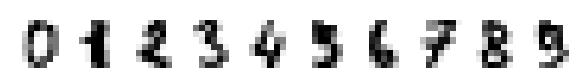

In [3]:
# Plot an example of each image.
fig = plt.figure(figsize=(10, 1), dpi=100)
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.matshow(digits.images[i], cmap='binary') 
    ax.axis('off')
plt.show()

## Generalization of the layers

[Part 4](http://peterroelants.github.io/posts/neural_network_implementation_part04/) of this tutorial series took on the classical view of neural networks where each layer consists of a [linear transformation](https://en.wikipedia.org/wiki/Linear_map) by a [matrix multiplication](https://en.wikipedia.org/wiki/Transformation_matrix) and vector addition followed by a non-linear function.  
Here the linear transformation is split from the non-linear function and each is abstracted into its own layer. This has the benefit that the forward and backward step of each layer can easily be calculated separately.

This tutorial defines three example layers as [Python classes](https://docs.python.org/2/tutorial/classes.html):

* A layer to apply the linear transformation (`LinearLayer`).
* A layer to apply the logistic function (`LogisticLayer`).
* A layer to compute the softmax classification probabilities at the output (`SoftmaxOutputLayer`).

Each layer can compute its output in the forward step with `get_output`, which can then be used as the input for the next layer. The gradient at the input of each layer in the backpropagation step can be computed with `get_input_grad`. This function computes the gradient with the help of the targets if it's the last layer, or the gradients at its outputs (gradients at input of next layer) if it's an intermediate layer.
Each layer has the option to [iterate](https://docs.python.org/2/library/stdtypes.html#iterator-types) over the parameters (if any) with `get_params_iter`, and get the gradients of these parameters in the same order with `get_params_grad`.

Notice that the gradient and cost computed by the softmax layer are divided by the number of input samples. This is to make this gradient and cost independent of the number of input samples so that the size of the mini-batches can be changed without affecting other parameters. More on this later.

In [4]:
# Define the non-linear functions used
def logistic(z): 
    return 1 / (1 + np.exp(-z))

def logistic_deriv(y):  # Derivative of logistic function
    return np.multiply(y, (1 - y))
    
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [5]:
# Define the layers used in this model
class Layer(object):
    """Base class for the different layers.
    Defines base methods and documentation of methods."""
    
    def get_params_iter(self):
        """Return an iterator over the parameters (if any).
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return []
    
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters.
        The list has the same order as the get_params_iter iterator.
        X is the input.
        output_grad is the gradient at the output of this layer.
        """
        return []
    
    def get_output(self, X):
        """Perform the forward step linear transformation.
        X is the input."""
        pass
    
    def get_input_grad(self, Y, output_grad=None, T=None):
        """Return the gradient at the inputs of this layer.
        Y is the pre-computed output of this layer (not needed in this case).
        output_grad is the gradient at the output of this layer 
         (gradient at input of next layer).
        Output layer uses targets T to compute the gradient based on the 
         output error instead of output_grad"""
        pass

In [6]:
class LinearLayer(Layer):
    """The linear layer performs a linear transformation to its input."""
    
    def __init__(self, n_in, n_out):
        """Initialize hidden layer parameters.
        n_in is the number of input variables.
        n_out is the number of output variables."""
        self.W = np.random.randn(n_in, n_out) * 0.1
        self.b = np.zeros(n_out)
        
    def get_params_iter(self):
        """Return an iterator over the parameters."""
        return itertools.chain(np.nditer(self.W, op_flags=['readwrite']),
                               np.nditer(self.b, op_flags=['readwrite']))
    
    def get_output(self, X):
        """Perform the forward step linear transformation."""
        return X.dot(self.W) + self.b
        
    def get_params_grad(self, X, output_grad):
        """Return a list of gradients over the parameters."""
        JW = X.T.dot(output_grad)
        Jb = np.sum(output_grad, axis=0)
        return [g for g in itertools.chain(np.nditer(JW), np.nditer(Jb))]
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return output_grad.dot(self.W.T)

In [7]:
class LogisticLayer(Layer):
    """The logistic layer applies the logistic function to its inputs."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return logistic(X)
    
    def get_input_grad(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        return np.multiply(logistic_deriv(Y), output_grad)

In [8]:
class SoftmaxOutputLayer(Layer):
    """The softmax output layer computes the classification propabilities at the output."""
    
    def get_output(self, X):
        """Perform the forward step transformation."""
        return softmax(X)
    
    def get_input_grad(self, Y, T):
        """Return the gradient at the inputs of this layer."""
        return (Y - T) / Y.shape[0]
    
    def get_cost(self, Y, T):
        """Return the cost at the output of this output layer."""
        return - np.multiply(T, np.log(Y)).sum() / Y.shape[0]

### Sample model

The following sections will refer to a layer as a layer defined above, and hidden-layer or output-layer as the classical neural network view of a linear transformation followed by a non-linear function.

The sample model used to classify the handwritten digits in this tutorial consists of two hidden-layers with logistic functions and a softmax output-layer. The fist hidden-layer takes a vector of 64 pixel values and transforms them to a vector of 20 values. The second hidden-layer projects the previous 20 values to 20 new values. The output-layer outputs probabilities for the 10 possible classes. This architecture is illustrated in the following figure (biases are not shown to keep figure clean).

![Image of the sample neural network model](https://raw.githubusercontent.com/peterroelants/peterroelants.github.io/master/notebooks/neural_net_implementation/img/SimpleANN05.png)

The full network is represented as a sequential list where each next layer is added on top of the previous layer by putting it in the next position in the list. The first layer is at position 0 in this list, the last layer is at the last index of this list.

In [9]:
# Define a sample model to be trained on the data
hidden_neurons_1 = 20  # Number of neurons in the first hidden-layer
hidden_neurons_2 = 20  # Number of neurons in the second hidden-layer
# Create the model
layers = [] # Define a list of layers
# Add first hidden layer
layers.append(LinearLayer(X_train.shape[1], hidden_neurons_1))
layers.append(LogisticLayer())
# Add second hidden layer
layers.append(LinearLayer(hidden_neurons_1, hidden_neurons_2))
layers.append(LogisticLayer())
# Add output layer
layers.append(LinearLayer(hidden_neurons_2, T_train.shape[1]))
layers.append(SoftmaxOutputLayer())

## Backpropagation

The details of how backpropagation works in the forward and backward step of vectorized model are explained in [part 4](http://peterroelants.github.io/posts/neural_network_implementation_part04/) of this tutorial. This section will only illustrate how to perform backpropagation over any number of layers with the generalized model described here.

### Forward step

The forward steps are computed by the `forward_step` method defined below. This method iteratively computes the outputs of each layer and feeds it as input to the next layer until the last layer. Each layer's output is computed by calling the `get_output` method. These output activations are stored in the `activations` list.

In [10]:
# Define the forward propagation step as a method.
def forward_step(input_samples, layers):
    """
    Compute and return the forward activation of each layer in layers.
    Input:
        input_samples: A matrix of input samples (each row is an input vector)
        layers: A list of Layers
    Output:
        A list of activations where the activation at each index i+1 corresponds to
        the activation of layer i in layers. activations[0] contains the input samples.  
    """
    activations = [input_samples] # List of layer activations
    # Compute the forward activations for each layer starting from the first
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X)  # Get the output of the current layer
        activations.append(Y)  # Store the output for future processing
        X = activations[-1]  # Set the current input as the activations of the previous layer
    return activations  # Return the activations of each layer

### Backward step

The gradients computed in the backward step are computed by the `backward_step` method defined below. The backward step goes over all the layers in the reversed order. It first gets the initial gradients from the output layer and uses these gradients to compute the gradients of the layers below by iteratively calling the `get_input_grad` method. During each step, it computes the gradients of the cost with respect to the parameters by calling the `get_params_grad` method and returns them in a list.

In [11]:
# Define the backward propagation step as a method
def backward_step(activations, targets, layers):
    """
    Perform the backpropagation step over all the layers and return the parameter gradients.
    Input:
        activations: A list of forward step activations where the activation at 
            each index i+1 corresponds to the activation of layer i in layers. 
            activations[0] contains the input samples. 
        targets: The output targets of the output layer.
        layers: A list of Layers corresponding that generated the outputs in activations.
    Output:
        A list of parameter gradients where the gradients at each index corresponds to
        the parameters gradients of the layer at the same index in layers. 
    """
    param_grads = collections.deque()  # List of parameter gradients for each layer
    output_grad = None  # The error gradient at the output of the current layer
    # Propagate the error backwards through all the layers.
    #  Use reversed to iterate backwards over the list of layers.
    for layer in reversed(layers):   
        Y = activations.pop()  # Get the activations of the last layer on the stack
        # Compute the error at the output layer.
        # The output layer error is calculated different then hidden layer error.
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:  # output_grad is not None (layer is not output layer)
            input_grad = layer.get_input_grad(Y, output_grad)
        # Get the input of this layer (activations of the previous layer)
        X = activations[-1]
        # Compute the layer parameter gradients used to update the parameters
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        # Compute gradient at output of previous layer (input of current layer):
        output_grad = input_grad
    return list(param_grads)  # Return the parameter gradients

## Gradient Checking

As in [part 4](http://peterroelants.github.io/posts/neural_network_implementation_part04/#Gradient-checking) of this tutorial the gradient computed by backpropagation is compared with the [numerical gradient](https://en.wikipedia.org/wiki/Numerical_differentiation) to assert that there are no bugs in the code to compute the gradients.

The code below gets the parameters of each layer by the help of the `get_params_iter` method that returns an iterator over all the parameters in the layer. The order of parameters returned corresponds to the order of parameter gradients returned by `get_params_grad` during backpropagation.

In [12]:
# Perform gradient checking
nb_samples_gradientcheck = 10 # Test the gradients on a subset of the data
X_temp = X_train[0:nb_samples_gradientcheck,:]
T_temp = T_train[0:nb_samples_gradientcheck,:]
# Get the parameter gradients with backpropagation
activations = forward_step(X_temp, layers)
param_grads = backward_step(activations, T_temp, layers)

# Set the small change to compute the numerical gradient
eps = 0.0001
# Compute the numerical gradients of the parameters in all layers.
for idx in range(len(layers)):
    layer = layers[idx]
    layer_backprop_grads = param_grads[idx]
    # Compute the numerical gradient for each parameter in the layer
    for p_idx, param in enumerate(layer.get_params_iter()):
        grad_backprop = layer_backprop_grads[p_idx]
        # + eps
        param += eps
        plus_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # - eps
        param -= 2 * eps
        min_cost = layers[-1].get_cost(forward_step(X_temp, layers)[-1], T_temp)
        # reset param value
        param += eps
        # calculate numerical gradient
        grad_num = (plus_cost - min_cost)/(2*eps)
        # Raise error if the numerical grade is not close to the backprop gradient
        if not np.isclose(grad_num, grad_backprop):
            raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_backprop)))
print('No gradient errors found')

No gradient errors found


## Stochastic gradient descent backpropagation

This tutorial uses a variant of gradient descent called [Stochastic gradient descent](http://research.microsoft.com/pubs/192769/tricks-2012.pdf) (SGD) to optimize the cost function. SGD follows the negative gradient of the cost function on subsets of the total training set. This has a few benefits: One of them is that the training time on large datasets can be reduced because the matrix of samples is much smaller during each sub-iteration and the gradients can be computed faster and with less memory. Another benefit is that computing the cost function on subsets results in noise, i.e. each subset will give a different cost depending on the samples. This will result in noisy (stochastic) gradient updates which might be able to push the gradient descent out of local minima. These, and other, benefits contribute to the popularity of SGD on training large scale machine learning methods such as neural networks.

The cost function needs to be independent of the number of input samples because the size of the subsets used during SGD can vary. This is why the [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) (MSE) cost function is used instead of just the squared error. Using the mean instead of the sum is reflected in the gradient and cost computed by the softmax layer being divided by the number of input samples.


### Minibatches

The subsets of the training set are often called mini-batches. The following code will divide the training set into mini-batches of around 25 samples per batch. The inputs and targets are combined together in a list of (input, target) tuples.

In [13]:
# Create the minibatches
batch_size = 25  # Approximately 25 samples per batch
nb_of_batches = X_train.shape[0] / batch_size  # Number of batches
# Create batches (X,Y) from the training set
XT_batches = zip(
    np.array_split(X_train, nb_of_batches, axis=0),  # X samples
    np.array_split(T_train, nb_of_batches, axis=0))  # Y targets

### SGD updates

The parameters $\mathbf{\theta}$ of the network are updated by the `update_params` method that iterates over each parameter of each layer and applies the simple [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) rule on each mini-batch: $\mathbf{\theta}(k+1) = \mathbf{\theta}(k) - \Delta \mathbf{\theta}(k+1)$. $\Delta \mathbf{\theta}$ is defined as: $\Delta \mathbf{\theta} = \mu \frac{\partial \xi}{\partial \mathbf{\theta}}$ with $\mu$ the learning rate.

The update steps will be performed for a number of iterations (`nb_of_iterations`) over the full training set, where each full iterations consists of multiple updates over the mini-batches. After each full iteration, the resulting network will be tested on the validation set. The training will stop if the cost on the validation set doesn't increase after three full iterations to prevent overfitting or after maximum 300 iterations. All costs will be stored in between for future analysis.

In [14]:
# Define a method to update the parameters
def update_params(layers, param_grads, learning_rate):
    """
    Function to update the parameters of the given layers with the given gradients
    by gradient descent with the given learning rate.
    """
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in itertools.izip(layer.get_params_iter(), layer_backprop_grads):
            # The parameter returned by the iterator point to the memory space of
            #  the original layer and can thus be modified inplace.
            param -= learning_rate * grad  # Update each parameter

In [15]:
# Perform backpropagation
# initalize some lists to store the cost for future analysis        
minibatch_costs = []
training_costs = []
validation_costs = []

max_nb_of_iterations = 300  # Train for a maximum of 300 iterations
learning_rate = 0.1  # Gradient descent learning rate

# Train for the maximum number of iterations
for iteration in range(max_nb_of_iterations):
    for X, T in XT_batches:  # For each minibatch sub-iteration
        activations = forward_step(X, layers)  # Get the activations
        minibatch_cost = layers[-1].get_cost(activations[-1], T)  # Get cost
        minibatch_costs.append(minibatch_cost)
        param_grads = backward_step(activations, T, layers)  # Get the gradients
        update_params(layers, param_grads, learning_rate)  # Update the parameters
    # Get full training cost for future analysis (plots)
    activations = forward_step(X_train, layers)
    train_cost = layers[-1].get_cost(activations[-1], T_train)
    training_costs.append(train_cost)
    # Get full validation cost
    activations = forward_step(X_validation, layers)
    validation_cost = layers[-1].get_cost(activations[-1], T_validation)
    validation_costs.append(validation_cost)
    if len(validation_costs) > 3:
        # Stop training if the cost on the validation set doesn't decrease
        #  for 3 iterations
        if validation_costs[-1] >= validation_costs[-2] >= validation_costs[-3]:
            break
    
nb_of_iterations = iteration + 1  # The number of iterations that have been executed

The costs stored during training can be plotted to visualize the performance during training. The resulting plot is shown in the next figure. The cost on the training samples and validation samples goes down very quickly and flattens out after about 40 iterations on the full training set. Notice that the cost on the training set is lower than the cost on the validation set, this is because the network is optimized on the training set and is slightly overfitting. The training stops after around 90 iterations because the validation cost stops decreasing.  
Also, notice that the cost of the mini-batches fluctuates around the cost of the full training set. This is the stochastic effect of mini-batches in SGD.

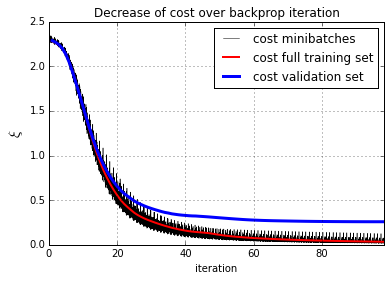

In [16]:
# Plot the minibatch, full training set, and validation costs
minibatch_x_inds = np.linspace(0, nb_of_iterations, num=nb_of_iterations*nb_of_batches)
iteration_x_inds = np.linspace(1, nb_of_iterations, num=nb_of_iterations)
# Plot the cost over the iterations
plt.plot(minibatch_x_inds, minibatch_costs, 'k-', linewidth=0.5, label='cost minibatches')
plt.plot(iteration_x_inds, training_costs, 'r-', linewidth=2, label='cost full training set')
plt.plot(iteration_x_inds, validation_costs, 'b-', linewidth=3, label='cost validation set')
# Add labels to the plot
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.legend()
x1,x2,y1,y2 = plt.axis()
plt.axis((0,nb_of_iterations,0,2.5))
plt.grid()
plt.show()

## Performance on the test set

Finally, the [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) on the independent test set is computed to measure the performance of the model. The [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) `accuracy_score` method is used to compute this accuracy from the predictions made by the model. The final accuracy on the test set is $96\%$ as shown below.

The results can be analyzed in more detail with the help of a [confusion table](https://en.wikipedia.org/wiki/Confusion_matrix). This table shows how many samples of which class are classified as one of the possible classes. The confusion table is shown in the figure below. It is computed by the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) `confusion_matrix` method.  
Notice that the digit '8' is misclassified five times, two times as '2', two times as '5', and one time as '9'.

In [17]:
# Get results of test data
y_true = np.argmax(T_test, axis=1)  # Get the target outputs
activations = forward_step(X_test, layers)  # Get activation of test samples
y_pred = np.argmax(activations[-1], axis=1)  # Get the predictions made by the network
test_accuracy = metrics.accuracy_score(y_true, y_pred)  # Test set accuracy
print('The accuracy on the test set is {:.2f}'.format(test_accuracy))

The accuracy on the test set is 0.96


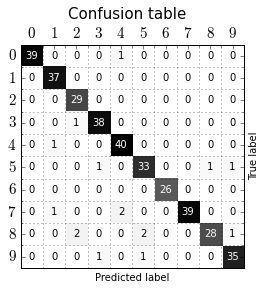

In [18]:
# Show confusion table
conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=None)  # Get confustion matrix
# Plot the confusion table
class_names = ['${:d}$'.format(x) for x in range(0, 10)]  # Digit class names
fig = plt.figure()
ax = fig.add_subplot(111)
# Show class labels on each axis
ax.xaxis.tick_top()
major_ticks = range(0,10)
minor_ticks = [x + 0.5 for x in range(0, 10)]
ax.xaxis.set_ticks(major_ticks, minor=False)
ax.yaxis.set_ticks(major_ticks, minor=False)
ax.xaxis.set_ticks(minor_ticks, minor=True)
ax.yaxis.set_ticks(minor_ticks, minor=True)
ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
# Set plot labels
ax.yaxis.set_label_position("right")
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
fig.suptitle('Confusion table', y=1.03, fontsize=15)
# Show a grid to seperate digits
ax.grid(b=True, which=u'minor')
# Color each grid cell according to the number classes predicted
ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
# Show the number of samples in each cell
for x in xrange(conf_matrix.shape[0]):
    for y in xrange(conf_matrix.shape[1]):
        color = 'w' if x == y else 'k'
        ax.text(x, y, conf_matrix[y,x], ha="center", va="center", color=color)       
plt.show()

This post at [peterroelants.github.io](http://peterroelants.github.io/posts/neural_network_implementation_part05/) is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/neural_net_implementation/neural_network_implementation_part05.ipynb)